Project 3 - Activity Classification
Josh Mandzak, Tanner Thornton, Coby White

First up, grab and collect all the data

In [8]:
import pandas as pd
import os

directories = ['Downstairs', 'Upstairs', 'Walking data', 'Squats']
dataframes = [
    [],
    [],
    [],
    []
]
cwd = os.getcwd()
cols_to_drop = ['LINEAR ACCELERATION X (m/s²)', 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)', 'LIGHT (lux)']
 
for i in range(3):
    path = cwd + '/' + directories[i]
    for filename in os.listdir(path):
        df = pd.read_csv(path + '/' + filename, sep=';')
        df.drop(columns=df.columns[16:], axis=1,  inplace=True)
        df.drop(columns=cols_to_drop, inplace=True)
        dataframes[i].append(df)


In [9]:
# Now read the files from the other app
for i in range(3, 4):
    path = cwd + '/' + directories[i] + '/'
    temp_dfs = []
    for filename in os.listdir(path):
        df = pd.read_csv(path + filename)
        df.drop(columns=['seconds_elapsed'], inplace=True)
        df = df.iloc[::50, :]
        temp_dfs.append(df)

    main_df = temp_dfs[0]
    for i in range(1, len(temp_dfs)):
        main_df = pd.merge(main_df, temp_dfs[i], on='time')
    main_df.drop(columns=['time'], inplace=True)
    dataframes[i].append(main_df)

In [13]:
print(len(dataframes))
print(len(dataframes[3]))

4
1


### Create Function to Split Dataframes into Samples 4 seconds long (8 samples)

In [14]:
def splitSamples(dataframes: list, samples_per_split: int) -> list:
    all_samples = []
    for df in dataframes:
        for i in range((len(df) // samples_per_split)):
            start_index = i*samples_per_split
            end_index = (i*samples_per_split) + samples_per_split
            temp_df = df[start_index:end_index]
            all_samples.append(temp_df)
    
    return all_samples

In [103]:
# Call the function with each dataframe to get sample lists
SAMPLES_PER_SPLIT = 4
downstairs_dfs = splitSamples(dataframes[0], SAMPLES_PER_SPLIT)
upstairs_dfs = splitSamples(dataframes[1], SAMPLES_PER_SPLIT)
walk_dfs = splitSamples(dataframes[2], SAMPLES_PER_SPLIT)
squat_dfs = splitSamples(dataframes[3], SAMPLES_PER_SPLIT)


In [104]:
print(len(downstairs_dfs))
print(len(upstairs_dfs))
print(len(walk_dfs))
print(len(squat_dfs))
print(squat_dfs[0].columns)

609
629
7168
54
Index(['ACCELEROMETER Z (m/s²)', 'ACCELEROMETER Y (m/s²)',
       'ACCELEROMETER X (m/s²)', 'MAGNETIC FIELD Z (μT)',
       'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD X (μT)', 'GYROSCOPE Z (rad/s)',
       'GYROSCOPE Y (rad/s)', 'GYROSCOPE X (rad/s)', 'GRAVITY Z (m/s²)',
       'GRAVITY Y (m/s²)', 'GRAVITY X (m/s²)'],
      dtype='object')


### Get the dataframes into something readable

In [105]:
# function to create list of lists from list of dataframes
def createX(dataframes: list, columns_to_use: list) -> list:
    X = []
    for df in dataframes:
        sample = []
        for column in columns_to_use:
            sample.append(df[column].tolist())
            
            # EXPERIMENTAL FEATURE COLLECTION
            # additional_features = []
            # measurement = df[column].tolist()
            # additional_features.append(np.mean(measurement))
            # additional_features.append(np.std(measurement))
            # sample.append(additional_features)

        flat_sample = [item for sublist in sample for item in sublist]
        X.append(flat_sample.copy())
    
    return X

In [106]:
# COLUMNS WE ARE USING
used_columns = ['ACCELEROMETER Z (m/s²)', 'ACCELEROMETER Y (m/s²)',
       'ACCELEROMETER X (m/s²)', 'MAGNETIC FIELD Z (μT)',
       'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD X (μT)', 'GYROSCOPE Z (rad/s)',
       'GYROSCOPE Y (rad/s)', 'GYROSCOPE X (rad/s)', 'GRAVITY Z (m/s²)',
       'GRAVITY Y (m/s²)', 'GRAVITY X (m/s²)']
       
# create list of lists for each activity
downstairs_samples = createX(downstairs_dfs, used_columns)
upstairs_samples = createX(upstairs_dfs, used_columns)
walk_samples = createX(walk_dfs, used_columns)
squat_samples = createX(squat_dfs, used_columns)

In [107]:
print(len(downstairs_samples))
print(len(upstairs_samples))
print(len(walk_samples))
print(len(squat_samples))

609
629
7168
54


In [108]:
# DOWNSAMPLING WALKING, PLAY WITH REMOVING OR ADDING IT
walk_samples = walk_samples[:600]
# walk_samples = walk_samples[:300]

### Some more preprocessing and creation of y

In [109]:
# Create y
y = []

for i in range(len(downstairs_samples)):
    y.append(0)
for i in range(len(upstairs_samples)):
    y.append(1)
for i in range(len(walk_samples)):
    y.append(2)
for i in range(len(squat_samples)):
    y.append(3)

# Create full X list
X = downstairs_samples + upstairs_samples + walk_samples + squat_samples

# # split into training and test data
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Scale X
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

### Plug it into a model and see how it does

In [110]:
# Train and evaluate the model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_model(X, y, model):
    # Do the K-fold cross validation
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    # print(f'Average accuracy of all folds: {round(np.mean(scores) * 100, 2)}%')

    # This function sets an empty array of size len(y)
    # It then does the predictions for each fold (retraining the model each time)
    # and fills in the prediction in the correct spot in the array. By the end of it,
    # you will have your y array and a new array (predictions) of guesses for each sample
    # this is because Kfold uses each sample once for test data.
    predictions = cross_val_predict(model, X, y, cv=cv)

    # we can use this to create a confusion matrix
    new_labels = ['Downstairs', 'Upstairs', 'Walking', 'Squat']
    old_labels = [0, 1, 2, 3]
    cm = confusion_matrix(y, predictions)
    plt.matshow(cm, cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xticks(ticks=old_labels, labels=new_labels)
    plt.yticks(ticks=old_labels, labels=new_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Label')
    
    print(f'All accuracy scores from 10 folds:')
    for score in scores:
        print(f'{round(score * 100, 2)}%', end=' ')
    print()
    print(f'Mean Accuracy from 10 Fold Cross-Validation: {round(np.mean(scores)*100, 2)}%\n')

All accuracy scores from 10 folds:
68.95% 72.11% 78.31% 79.89% 77.78% 78.84% 92.59% 65.61% 62.43% 65.61% 
Mean Accuracy from 10 Fold Cross-Validation: 74.21%



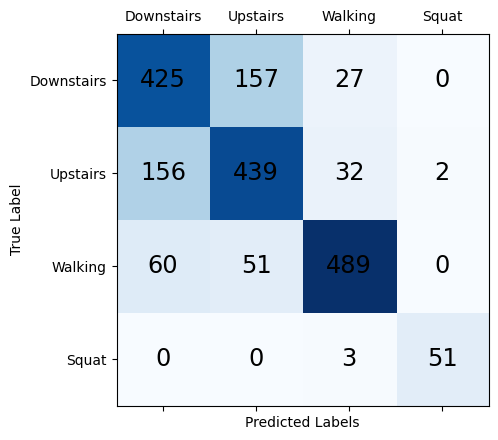

In [111]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
# model = XGBClassifier()
train_and_evaluate_model(X, y, model)